# List of requirement packages

```bash
pip install gensim
pip install bisect
pip install dawg
pip install marisa_trie
pip install hat_trie
pip install datrie
```

In [1]:
from gensim.corpora import WikiCorpus


def create_corpus(filepath='data/sw/swwiki-latest-pages-articles.xml.bz2'):
    wiki = WikiCorpus(filepath, lemmatize=False)

    dset = (str(w) for x in wiki.get_texts() for w in x)
    with open('data/text.txt', 'w') as output:
        output.write("\n".join(dset) + "\n")

    dset = sorted((x for x in wiki.dictionary.itervalues()))
    with open('data/dict.txt', 'w') as output:
        output.write("\n".join(dset) + "\n")


# Create corpus

In [2]:
!mkdir -p data/sw/
!wget -P data/sw/ https://dumps.wikimedia.org/swwiki/latest/swwiki-latest-pages-articles.xml.bz2
create_corpus()

In [3]:
!head data/dict.txt

a_agadez_hotel
a_brown_sofa_
a_id
aa
aa_large
aaa
aaadir
aaah
aab
aabayo


In [4]:
!head data/text.txt

wanaakiolojia
wakichimba
kwenye
misingi
ya
maghofu
ya
monasteri
huko
sweden


In [5]:
!ls -lh data/*.txt

-rw-rw-r-- 1 dsysoev dsysoev 2,6M янв  5 11:37 data/dict.txt
-rw-rw-r-- 1 dsysoev dsysoev  40M янв  5 11:37 data/text.txt


# Evaluate the speed of search and memory usage for various data structures

In [6]:
%load_ext autoreload
%autoreload 2

%load_ext memory_profiler

In [7]:
%%writefile load_data.py

import string
import bisect
import dawg
import marisa_trie
import hat_trie
import datrie


def load_as_list(filepath):
    
    with open(filepath, 'r') as f:
        data = [x.rstrip() for x in f.readlines()]
    return data


def load_as_set(filepath):
    
    with open(filepath, 'r') as f:
        data = {x.rstrip() for x in f.readlines()}
    return data


def bisect_index(a, x):
    i = bisect.bisect_left(a, x)
    if i != len(a) and a[i] == x:
        return i
    return -1


def load_as_dawg(filepath):
    
    with open(filepath, 'r') as f:
        data = dawg.DAWG(x.rstrip() for x in f.readlines())
    return data


def load_as_marisatrie(filepath):
    
    with open(filepath, 'r') as f:
        data = marisa_trie.Trie(x.rstrip() for x in f.readlines())
    return data


def load_as_hattrie(filepath):
    
    with open(filepath, 'r') as f:
        data = hat_trie.Trie()
        for x in f.readlines():
            data[x.rstrip()] = 0
    return data


def load_as_datrie(filepath):

    with open(filepath, 'r') as f:
        lines = (x.rstrip() for x in f.readlines())
    
    data = datrie.Trie(string.printable)
    for x in lines:
        data[x] = 0
    return data


Overwriting load_data.py


In [8]:
n_times = 3
results = {}
filepath_list = ['data/dict.txt', 'data/text.txt']

# List

In [9]:
from load_data import load_as_list

corpus = load_as_list('dict.txt')

[x in corpus for x in ['hello', 'World']]

[True, False]

In [10]:
from load_data import load_as_list

import gc

del _
gc.collect()

dtype = 'list'
results[dtype] = []
for filepath in filepath_list:
    s = %memit -o _ = load_as_list(filepath)
    mem_usage = s.mem_usage[0] - s.baseline
    results[dtype].append(mem_usage)
    

peak memory: 178.93 MiB, increment: 54.02 MiB
peak memory: 981.54 MiB, increment: 833.61 MiB


In [11]:
import timeit

for filepath in filepath_list:
    time = timeit.Timer("[x in corpus for x in ['hello', 'World']]",
                        "from load_data import load_as_list;"
                        "corpus = load_as_list('{}')".format(filepath))
    lookup_time = time.timeit(n_times) / n_times
    results[dtype].append(lookup_time)
    
    print(filepath, lookup_time)

data/dict.txt 0.004184225671148549
data/text.txt 0.07214392633371365


# Set

In [12]:
from load_data import load_as_set

corpus = load_as_set('dict.txt')

[x in corpus for x in ['hello', 'World']]

[True, False]

In [13]:
from load_data import load_as_set

import gc

del _
gc.collect()

dtype = 'set'
results[dtype] = []
for filepath in filepath_list:
    s = %memit -o _ = load_as_set(filepath)
    mem_usage = s.mem_usage[0] - s.baseline
    results[dtype].append(mem_usage)
    

peak memory: 204.22 MiB, increment: 68.45 MiB
peak memory: 609.59 MiB, increment: 452.48 MiB


In [14]:
import timeit

for filepath in filepath_list:
    time = timeit.Timer("[x in corpus for x in ['hello', 'World']]",
                        "from load_data import load_as_set;"
                        "corpus = load_as_set('{}')".format(filepath))
    lookup_time = time.timeit(n_times) / n_times
    results[dtype].append(lookup_time)
    
    print(filepath, lookup_time)

data/dict.txt 2.980009109402696e-06
data/text.txt 3.203332501774033e-06


# Bisect

In [15]:
from load_data import load_as_list, bisect_index

corpus = tuple(sorted(load_as_list('dict.txt')))

[bisect_index(corpus, x) != -1 for x in ['hello', 'World']]

[True, False]

In [16]:
from load_data import load_as_list

import gc

del _
gc.collect()

dtype = 'bisect'
results[dtype] = []
for filepath in filepath_list:
    s = %memit -o _ = tuple(sorted(load_as_list(filepath)))
    mem_usage = s.mem_usage[0] - s.baseline
    results[dtype].append(mem_usage)
    

peak memory: 179.18 MiB, increment: 50.40 MiB
peak memory: 987.69 MiB, increment: 836.54 MiB


In [17]:
import timeit

for filepath in filepath_list:
    time = timeit.Timer("[bisect_index(corpus, x) != -1 for x in ['hello', 'World']]",
                        "from load_data import load_as_list, bisect_index;"
                        "corpus = tuple(sorted(load_as_list('{}')))".format(filepath))
    lookup_time = time.timeit(n_times) / n_times
    results[dtype].append(lookup_time)
    
    print(filepath, lookup_time)

data/dict.txt 1.2276994918162623e-05
data/text.txt 1.38026662170887e-05


# DAWG

pip install dawg

In [18]:
from load_data import load_as_dawg

corpus = load_as_dawg('dict.txt')

[x in corpus for x in ['hello', 'World']]

[True, False]

In [19]:
from load_data import load_as_dawg

import gc

del _
gc.collect()

dtype = 'dawg'
results[dtype] = []
for filepath in filepath_list:
    s = %memit -o _ = load_as_dawg(filepath)
    mem_usage = s.mem_usage[0] - s.baseline
    results[dtype].append(mem_usage)
    

peak memory: 162.96 MiB, increment: 12.99 MiB
peak memory: 885.73 MiB, increment: 735.75 MiB


In [20]:
import timeit

for filepath in filepath_list:
    time = timeit.Timer("[x in corpus for x in ['hello', 'World']]",
                        "from load_data import load_as_dawg;"
                        "corpus = load_as_dawg('{}')".format(filepath))
    lookup_time = time.timeit(n_times) / n_times
    results[dtype].append(lookup_time)
    
    print(filepath, lookup_time)

data/dict.txt 3.642664523795247e-06
data/text.txt 4.433328285813332e-06


# Marisa Trie

In [21]:
from load_data import load_as_marisatrie

corpus = load_as_marisatrie('dict.txt')

[x in corpus for x in ['hello', 'World']]

[True, False]

In [22]:
from load_data import load_as_marisatrie

import gc

del _
gc.collect()

dtype = 'marisa_trie'
results[dtype] = []
for filepath in filepath_list:
    s = %memit -o _ = load_as_marisatrie(filepath)
    mem_usage = s.mem_usage[0] - s.baseline
    results[dtype].append(mem_usage)


peak memory: 166.36 MiB, increment: 14.25 MiB
peak memory: 661.55 MiB, increment: 509.53 MiB


In [23]:
import timeit

for filepath in filepath_list:
    time = timeit.Timer("[x in corpus for x in ['hello', 'World']]",
                        "from load_data import load_as_marisatrie;"
                        "corpus = load_as_marisatrie('{}')".format(filepath))
    lookup_time = time.timeit(n_times) / n_times
    results[dtype].append(lookup_time)
    
    print(filepath, lookup_time)

data/dict.txt 7.235668211554487e-06
data/text.txt 7.050335019206007e-06


# Hat Trie

In [24]:
from load_data import load_as_hattrie

corpus = load_as_hattrie('dict.txt')

[x in corpus for x in ['hello', 'World']]

[True, False]

In [25]:
from load_data import load_as_hattrie

import gc

del _
gc.collect()

dtype = 'hat_trie'
results[dtype] = []
for filepath in filepath_list:
    s = %memit -o _ = load_as_hattrie(filepath)
    mem_usage = s.mem_usage[0] - s.baseline
    results[dtype].append(mem_usage)


peak memory: 260.84 MiB, increment: 14.10 MiB
peak memory: 615.82 MiB, increment: 369.33 MiB


In [26]:
import timeit

for filepath in filepath_list:
    time = timeit.Timer("[x in corpus for x in ['hello', 'World']]",
                        "from load_data import load_as_hattrie;"
                        "corpus = load_as_hattrie('{}')".format(filepath))
    lookup_time = time.timeit(n_times) / n_times
    results[dtype].append(lookup_time)
    
    print(filepath, lookup_time)


data/dict.txt 4.936339488873879e-06
data/text.txt 4.933332093060017e-06


# Datrie

In [27]:
from load_data import load_as_datrie

corpus = load_as_datrie('dict.txt')

[x in corpus for x in ['hello', 'World']]

[True, False]

In [28]:
from load_data import load_as_datrie

import gc

del _
gc.collect()

dtype = 'datrie'
results[dtype] = []
for filepath in filepath_list:
    s = %memit -o _ = load_as_datrie(filepath)
    mem_usage = s.mem_usage[0] - s.baseline
    results[dtype].append(mem_usage)


peak memory: 260.86 MiB, increment: 13.74 MiB
peak memory: 615.85 MiB, increment: 368.60 MiB


In [29]:
import timeit

for filepath in filepath_list:
    time = timeit.Timer("[x in corpus for x in ['hello', 'World']]",
                        "from load_data import load_as_datrie;"
                        "corpus = load_as_datrie('{}')".format(filepath))
    lookup_time = time.timeit(n_times) / n_times
    results[dtype].append(lookup_time)
    
    print(filepath, lookup_time)


data/dict.txt 4.630341815451781e-06
data/text.txt 4.563664939875404e-06


In [30]:
import pandas as pd

df = pd.DataFrame(results, index=['memory usage dict, Mb', 'memory usage text, Mb', 'lookup dict, ms', 'lookup text, ms']).T
df['lookup dict, ms'] *= 1e6
df['lookup text, ms'] *= 1e6

df = df.round(2)
df = df.reset_index()
df.rename(columns={'index': 'label'}, inplace=True)

df

,label,"memory usage dict, Mb","memory usage text, Mb","lookup dict, ms","lookup text, ms"
0,list,54.02,833.61,4184.23,72143.93
1,set,68.45,452.48,2.98,3.20
2,bisect,50.40,836.54,12.28,13.80
3,dawg,12.99,735.75,3.64,4.43
4,marisa_trie,14.25,509.53,7.24,7.05
5,hat_trie,14.10,369.33,4.94,4.93
6,datrie,13.74,368.60,4.63,4.56


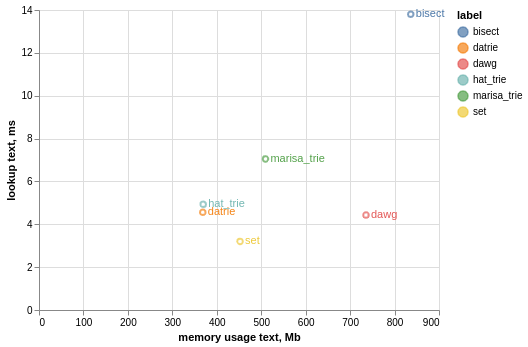

In [31]:
import altair as alt

points = alt.Chart(df.iloc[1:]).mark_point().encode(
    x='memory usage text, Mb:Q',
    y='lookup text, ms:Q',
    color='label'
)

text = points.mark_text(
    align='left',
    baseline='middle',
    dx=5
).encode(
    text='label'
)

points + text

# Conclution

- Set - best performance and low memory usage

# Useful links

- http://kmike.ru/python-data-structures/